In [1]:
import re
import numpy as np
import pandas as pd
import gensim
from nltk.tokenize import word_tokenize
from gensim.models import Word2Vec,FastText
from nltk.corpus import stopwords
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, Flatten, Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.regularizers import l1
from tensorflow.keras.layers import Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

In [2]:
data=pd.read_csv(r'D:\CODING\Python\NLP\END_SEM\IMDB Dataset.csv')

In [3]:
data.dropna(inplace=True)

In [4]:
data

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative


In [5]:
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    tokens = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    return tokens

data['review'] = data['review'].apply(preprocess_text)

label_encoder = LabelEncoder()
data['label'] = label_encoder.fit_transform(data['sentiment'])

num_classes = len(label_encoder.classes_)
y_one_hot = to_categorical(data['label'], num_classes=num_classes)


In [6]:
data

,review,sentiment,label
0,"[one, reviewers, mentioned, watching, oz, epis...",positive,1
1,"[wonderful, little, production, br, br, filmin...",positive,1
2,"[thought, wonderful, way, spend, time, hot, su...",positive,1
3,"[basically, theres, family, little, boy, jake,...",negative,0
4,"[petter, matteis, love, time, money, visually,...",positive,1
...,...,...,...
49995,"[thought, movie, right, good, job, wasnt, crea...",positive,1
49996,"[bad, plot, bad, dialogue, bad, acting, idioti...",negative,0
49997,"[catholic, taught, parochial, elementary, scho...",negative,0
49998,"[im, going, disagree, previous, comment, side,...",negative,0


In [7]:
def load_glove(glove_file):
    with open(glove_file, 'r', encoding='utf-8') as f:
        word_embeddings = {}
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], dtype='float32')
            word_embeddings[word] = vector
    return word_embeddings

def generate_embedding_matrix(word_vector, embedding_model, embedding_type, max_length=200):
    if embedding_type == 'glove':
        embedding_dim = len(next(iter(embedding_model.values())))
        embedding_matrix = np.zeros((max_length, embedding_dim))
        for i, word in enumerate(word_vector):
            if word in embedding_model:
                embedding_matrix[i] = embedding_model[word]
            if i >= max_length - 1:
                break
    else:
        word_embeddings = []
        for word in word_vector:
            if word in embedding_model.wv:
                word_embedding = embedding_model.wv[word]
                word_embeddings.append(word_embedding)
        embedding_matrix = np.array(word_embeddings)
        if len(embedding_matrix) < max_length:
            embedding_matrix = np.pad(embedding_matrix, ((0, max_length - len(embedding_matrix)), (0, 0)), mode='constant')
        else:
            embedding_matrix = embedding_matrix[:max_length, :]
    return embedding_matrix

def train_word2vec(corpus, vector_size=100, window=10, min_count=1, workers=4, sg=1):
    return Word2Vec(sentences=corpus, vector_size=vector_size, window=window, min_count=min_count, workers=workers, sg=sg)

def train_fasttext(corpus, vector_size=100, window=10, min_count=1, workers=4, sg=1):
    return FastText(sentences=corpus, vector_size=vector_size, window=window, min_count=min_count, workers=workers, sg=sg)

def choose_embedding_model(corpus, model_type, glove_file):
    if model_type == 'word2vec':
        model = train_word2vec(corpus)
    elif model_type == 'fasttext':
        model = train_fasttext(corpus)
    elif model_type == 'glove' and glove_file is not None:
        model = load_glove(glove_file)
    else:
        raise ValueError("Invalid model type or missing GloVe file.")
    return model

In [8]:
tokenized_corpus=data['review'].to_list()

In [9]:
embedding_type = 'word2vec' 
embedding_model = choose_embedding_model(tokenized_corpus, model_type=embedding_type, glove_file=r'D:\CODING\Python\NLP\END_SEM\glove\eng\glove.6B.100d.txt')

data['embedding_matrix'] = data['review'].apply(lambda x: generate_embedding_matrix(x, embedding_model, embedding_type))

X = np.array(data['embedding_matrix'].tolist())


X_train, X_test, y_train, y_test = train_test_split(X, y_one_hot, test_size=0.2, random_state=42)

input_shape = X_train.shape[1:]

In [10]:
def create_cnn_model(input_shape, num_classes=2):
    model = Sequential()
    model.add(Conv1D(64, kernel_size=3, activation='relu', input_shape=input_shape))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Conv1D(128, kernel_size=3, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Conv1D(256, kernel_size=3, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Conv1D(512, kernel_size=3, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(512, activation='relu', kernel_regularizer=l1(0.01)))  # L1 regularization with lambda=0.01
    model.add(Dense(256, activation='relu', kernel_regularizer=l1(0.01)))  # L1 regularization with lambda=0.01
    model.add(Dense(128, activation='relu', kernel_regularizer=l1(0.01)))  # L1 regularization with lambda=0.01
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    return model

input_shape = X.shape[1:]
model = create_cnn_model(input_shape)


d:\ANACONDA\envs\tensorflow\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [11]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 198, 64)        │        19,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 99, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 97, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 48, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 46, 256)        │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 23, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 21, 512)        │       393,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 10, 512)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 5120)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     2,621,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,322,690 (12.68 MB)

 Trainable params: 3,322,690 (12.68 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:
model.fit(X_train, y_train, epochs=30, batch_size=128, validation_split=0.2)

Epoch 1/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 25s 84ms/step - accuracy: 0.6535 - loss: 112.1986 - val_accuracy: 0.8609 - val_loss: 3.7576
Epoch 2/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 21s 82ms/step - accuracy: 0.8603 - loss: 3.7542 - val_accuracy: 0.8664 - val_loss: 3.7077
Epoch 3/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 21s 83ms/step - accuracy: 0.8653 - loss: 3.7116 - val_accuracy: 0.8758 - val_loss: 3.7556
Epoch 4/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 20s 79ms/step - accuracy: 0.8742 - loss: 3.6918 - val_accuracy: 0.8876 - val_loss: 3.6559
Epoch 5/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 19s 78ms/step - accuracy: 0.8884 - loss: 3.6515 - val_accuracy: 0.8637 - val_loss: 3.6897
Epoch 6/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 20s 79ms/step - accuracy: 0.8887 - loss: 3.6497 - val_accuracy: 0.8915 - val_loss: 3.6542
Epoch 7/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 19s 77ms/step - accuracy: 0.8953 - loss: 3.6351 - val_accuracy: 0.8849 - val_loss: 3.6875
Epoch 8/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 19s 77ms/step - accuracy: 0.8951 - loss: 3.6332 

In [13]:
loss, accuracy = model.evaluate(X_test, y_test)
print("Test Accuracy:", accuracy)

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.8819 - loss: 3.7158
Test Accuracy: 0.8834999799728394


In [14]:
y_pred_one_hot = model.predict(X_test)

y_pred = np.argmax(y_pred_one_hot, axis=1) 
y_true = np.argmax(y_test, axis=1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step


In [15]:
report = classification_report(y_true, y_pred)
print("Classification Report:\n", report)


Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.88      0.88      4961
           1       0.88      0.89      0.88      5039

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



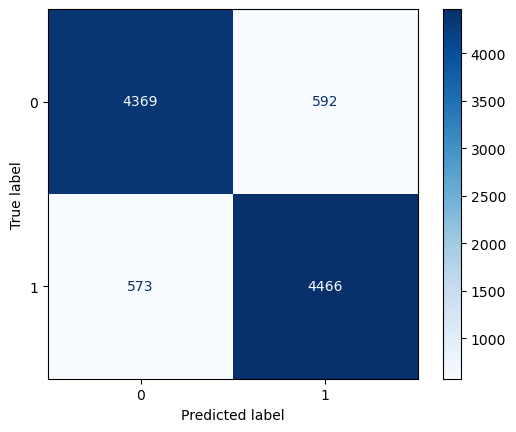

In [16]:
conf_matrix = confusion_matrix(y_true, y_pred)

ConfusionMatrixDisplay.from_predictions(y_true, y_pred,cmap=plt.cm.Blues)

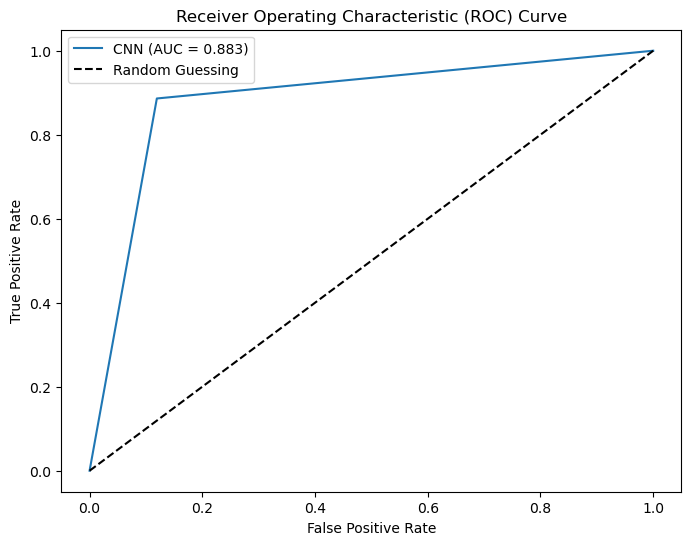

In [17]:
fpr, tpr, _ = roc_curve(y_true, y_pred)

# Calculate the AUC score
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='CNN (AUC = {:.3f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='best')
plt.show()

---

Using Glove